In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# Define the neural network model with sigmoid activation
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 64)
        self.hidden_layer2 = nn.Linear(64,64)
        self.output_layer = nn.Linear(64, 1)
        self.activation = torch.sigmoid

    def forward(self, x):
        x = self.activation(self.hidden_layer1(x))
        x = self.activation(self.hidden_layer2(x))
        return self.output_layer(x)

In [16]:
# Training the model
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 5000

In [17]:
# Define the Laplace equation: -Δu = 0
def pde_loss(model, points):
    points.requires_grad_(True)
    u = model(points)
    grads = torch.autograd.grad(
        u, points, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]
    u_x, u_y = grads[:, 0:1], grads[:, 1:2]
    u_xx = torch.autograd.grad(u_x, points, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(u_y, points, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    return ((u_xx + u_yy) ** 2).mean()

In [18]:
# Define boundary loss
def boundary_loss(model, boundary_points, boundary_values):
    u_pred = model(boundary_points)
    return ((u_pred - boundary_values) ** 2).mean()

In [19]:
# Generate collocation and boundary points
n_collocation = 1000
n_boundary = 200
collocation_points = torch.rand((n_collocation, 2))  # Random points in [0, 1] x [0, 1]

In [20]:
# Boundary points (x = 0, x = 1, y = 0, y = 1)
x = torch.linspace(0, 1, n_boundary)
boundary_points = torch.cat([
    torch.stack([torch.zeros_like(x), x], dim=1),  # Left (x=0)
    torch.stack([torch.ones_like(x), x], dim=1),  # Right (x=1)
    torch.stack([x, torch.zeros_like(x)], dim=1),  # Bottom (y=0)
    torch.stack([x, torch.ones_like(x)], dim=1)   # Top (y=1)
], dim=0)

boundary_values = torch.cat([
    torch.full((n_boundary,), 100.0),  # Left boundary: u = 100
    torch.zeros(3 * n_boundary)       # Other boundaries: u = 0
]).unsqueeze(1)

In [21]:
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    loss_pde = pde_loss(model, collocation_points)
    loss_bc = boundary_loss(model, boundary_points, boundary_values)
    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

  1%|          | 32/5000 [00:00<00:32, 153.86it/s]

Epoch 0, Loss: 2497.95458984375


 11%|█         | 531/5000 [00:02<00:22, 200.66it/s]

Epoch 500, Loss: 861.3885498046875


 21%|██        | 1036/5000 [00:05<00:18, 209.37it/s]

Epoch 1000, Loss: 350.3494567871094


 30%|███       | 1522/5000 [00:07<00:17, 196.98it/s]

Epoch 1500, Loss: 278.6291198730469


 41%|████      | 2034/5000 [00:10<00:14, 201.76it/s]

Epoch 2000, Loss: 240.20770263671875


 51%|█████     | 2526/5000 [00:13<00:13, 186.66it/s]

Epoch 2500, Loss: 227.5717010498047


 60%|██████    | 3019/5000 [00:15<00:09, 199.26it/s]

Epoch 3000, Loss: 218.0188751220703


 71%|███████   | 3528/5000 [00:19<00:07, 196.12it/s]

Epoch 3500, Loss: 209.23851013183594


 81%|████████  | 4028/5000 [00:21<00:04, 210.81it/s]

Epoch 4000, Loss: 203.17935180664062


 91%|█████████ | 4529/5000 [00:24<00:02, 207.58it/s]

Epoch 4500, Loss: 198.50563049316406


100%|██████████| 5000/5000 [00:26<00:00, 187.76it/s]


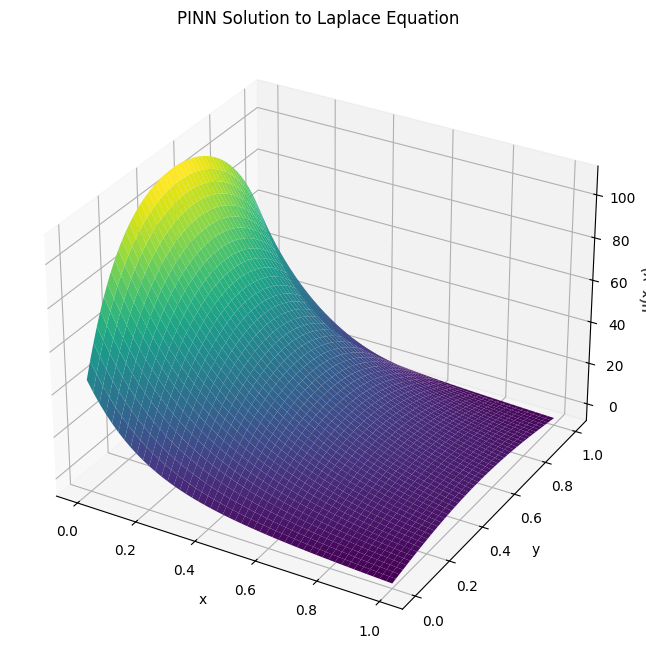

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Generate grid for plotting
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
XY = torch.tensor(np.column_stack([X.ravel(), Y.ravel()]), dtype=torch.float32)

# Predict solution on the grid
u_pred = model(XY).detach().numpy().reshape(X.shape)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_pred, cmap="viridis", edgecolor="none")
ax.set_title("PINN Solution to Laplace Equation")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x, y)")
plt.show()

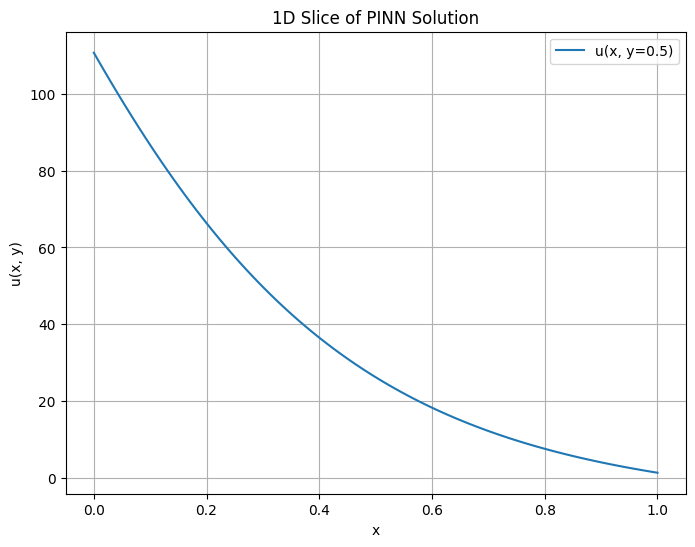

In [23]:
# Generate 1D data along a fixed y value (e.g., y = 0.5)
fixed_y = 0.5  # Fix y at 0.5
x_values = np.linspace(0, 1, 100)  # 100 points along x
xy_1d = torch.tensor(np.column_stack([x_values, np.full_like(x_values, fixed_y)]), dtype=torch.float32)

# Predict solution for the fixed y value
u_1d_pred = model(xy_1d).detach().cpu().numpy()

# Plot the 1D solution
plt.figure(figsize=(8, 6))
plt.plot(x_values, u_1d_pred, label=f"u(x, y={fixed_y})")
plt.title("1D Slice of PINN Solution")
plt.xlabel("x")
plt.ylabel("u(x, y)")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0, Loss: 2504.4296875
Epoch 500, Loss: 1824.073486328125
Epoch 1000, Loss: 1281.2662353515625
Epoch 1500, Loss: 1032.734619140625
Epoch 2000, Loss: 967.578125
Epoch 2500, Loss: 938.1959228515625
Epoch 3000, Loss: 910.79150390625
Epoch 3500, Loss: 857.6449584960938
Epoch 4000, Loss: 688.6521606445312
Epoch 4500, Loss: 479.2962646484375


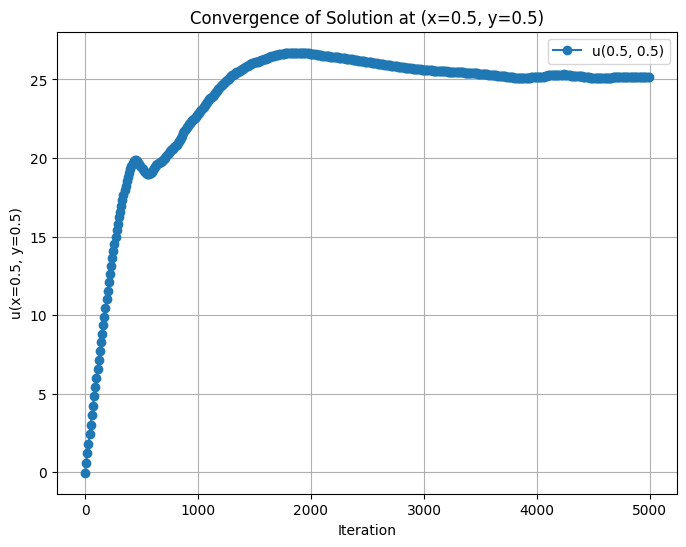

In [24]:
# Fixed spatial point for monitoring
fixed_point = torch.tensor([[0.5, 0.5]], dtype=torch.float32)

# Array to store predicted values at each iteration
convergence_values = []

# Training loop with monitoring
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5000

for epoch in range(epochs):
    optimizer.zero_grad()
    loss_pde = pde_loss(model, collocation_points)
    loss_bc = boundary_loss(model, boundary_points, boundary_values)
    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()

    # Store the prediction at the fixed point
    if epoch % 10 == 0:  # Record every 10 epochs to reduce noise
        u_fixed = model(fixed_point).detach().cpu().item()
        convergence_values.append(u_fixed)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Plot the convergence
iterations = np.arange(0, len(convergence_values)) * 10  # Iterations corresponding to recorded values
plt.figure(figsize=(8, 6))
plt.plot(iterations, convergence_values, label=f"u(0.5, 0.5)", marker="o")
plt.title("Convergence of Solution at (x=0.5, y=0.5)")
plt.xlabel("Iteration")
plt.ylabel("u(x=0.5, y=0.5)")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
torch.save(model.state_dict(), "PINN.pt")

In [26]:
model.load_state_dict(torch.load('PINN.pt'), strict=False)